# PyTorch transfer learning

Tranferring the weights of a pretrained model to use for our own. 

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.7.1+cu126
0.22.1+cpu


### Lets import the code we have already written.

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.


Cloning into 'pytorch-deep-learning'...
Updating files:  57% (142/248)
Updating files:  58% (144/248)
Updating files:  59% (147/248)
Updating files:  60% (149/248)
Updating files:  61% (152/248)
Updating files:  62% (154/248)
Updating files:  63% (157/248)
Updating files:  64% (159/248)
Updating files:  65% (162/248)
Updating files:  66% (164/248)
Updating files:  67% (167/248)
Updating files:  68% (169/248)
Updating files:  69% (172/248)
Updating files:  70% (174/248)
Updating files:  71% (177/248)
Updating files:  72% (179/248)
Updating files:  73% (182/248)
Updating files:  74% (184/248)
Updating files:  75% (186/248)
Updating files:  76% (189/248)
Updating files:  77% (191/248)
Updating files:  78% (194/248)
Updating files:  79% (196/248)
Updating files:  80% (199/248)
Updating files:  81% (201/248)
Updating files:  82% (204/248)
Updating files:  83% (206/248)
Updating files:  84% (209/248)
Updating files:  85% (211/248)
Updating files:  86% (214/248)
Updating files:  87% (216/248)

ModuleNotFoundError: No module named 'going_modular'

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get the data

Get our pizza sushi steak data to use.

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist then we download it
if image_path.is_dir():
    print("Directory already exists...")
else:
    print("Directory not found, downloading...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download the data
    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi, data...")
        f.write(request.content)


    # Unzip pizza , steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # remove zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Directory already exists...


In [5]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

In [6]:
from going_modular import data_setup

### Creating a transform for `torchvision.models` (manual creation)

In [7]:
from torchvision import transforms

# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [8]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x21ca5c6b880>,
 ['pizza', 'steak', 'sushi'])

## Creating a tranform for `torchvision.models` (auto creation)

With new version of torchvision automatic data transform is supported.

In [9]:
import torchvision
torchvision.__version__

'0.21.0+cu126'

In [10]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
# Fet the trnaforms used to create out pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x21c9e147010>,
 ['pizza', 'steak', 'sushi'])

## Getting a pretrained model

There are various places to get one:
- PyTorch domain libraries
- Libraties like `timm`
- hugging face
- papers with code

### Which pretrained model should you use??

Experiment, experiment, experiment

Three things to consider
- Speed
- SIze
- Performance on the chose problem

For our case EffNetB0 is our best option in terms of performance vs size.

### Setting up a pretrained model

Want to create an instance of pretrained effnet_B0.

In [28]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # DEFAULT is best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

C:\Users\zelaw\PycharmProjects\Gym\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zelaw\PycharmProjects\Gym\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [29]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [30]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### Getting a summary of our model with `torchinfo.summary`

In [31]:
# Print a summary with torchinfo
from torchinfo import summary

summary(model=model,
       input_size=(1, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### Freezing the base model and changing the output layer to suit our needs

We freeze the base layers and train the output layers.

In [32]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

In [33]:
len(class_names)

3

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Update the classifier head of model to suit our problem
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
             out_features=len(class_names))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [35]:
summary(model=model,
       input_size=(1, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Train model

In [36]:
# Define a loss and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
# import train function
from going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timer
from timeit import default_timer as  timer
start_time = timer()

# setup training and save the results
results = engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=5,
                      device=device)


# End the timer and print the time
end_time =  timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0974 | train_acc: 0.3789 | test_loss: 0.9128 | test_acc: 0.5729
Epoch: 2 | train_loss: 0.8843 | train_acc: 0.7383 | test_loss: 0.7944 | test_acc: 0.8507
Epoch: 3 | train_loss: 0.7696 | train_acc: 0.8047 | test_loss: 0.7504 | test_acc: 0.8021
Epoch: 4 | train_loss: 0.7116 | train_acc: 0.7539 | test_loss: 0.6408 | test_acc: 0.8785
Epoch: 5 | train_loss: 0.6287 | train_acc: 0.7773 | test_loss: 0.6312 | test_acc: 0.8785
[INFO] Total training time: 12.146 seconds


## Evaluate model by plotting loss curves

In [38]:
try:
    from helper_functions import plot_loss_curves
except:
    print("Failed to load it")

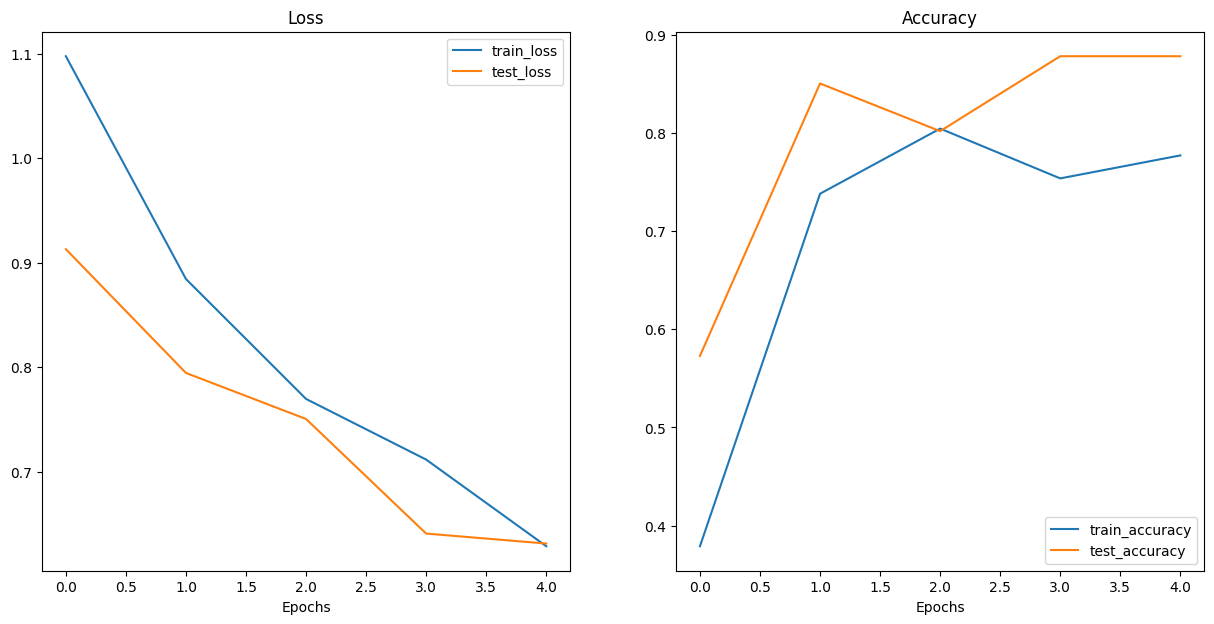

In [39]:
plot_loss_curves(results)

## Make prediction on images from the test set

### Let's write a function for this with some modifications

In [49]:
from typing import List, Tuple
from PIL import Image

from torchvision import transforms

def pred_and_plot_image(model: torch.nn.Module,
                       image_path: str,
                       class_names: List[str],
                       image_size: Tuple[int, int] = (224, 224),
                       transform: torchvision.transforms = None,
                       device: torch.device = device):
    # Open the image with PIL
    img = Image.open(image_path)

    # Create a tranform if one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
        ])

    ## Predict on image
    # Make sure the model is on target device
    model.to(device)

    # Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
        # Transform the image and add an extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on the tranformed image by passing it to the model and put the data on same device
        target_image_pred = model(transformed_image.to(device))

        #Convert the model's op logits to pred probs
        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        # Convert the model's pred probs to preds
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

        # PLot the image with predicted label and probability
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
        plt.axis("off")

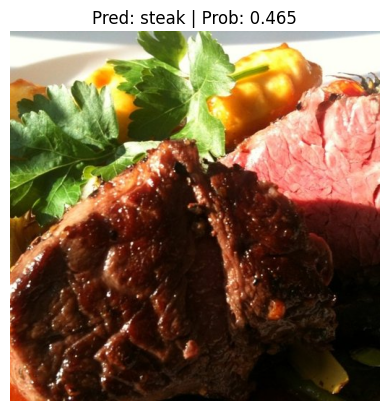

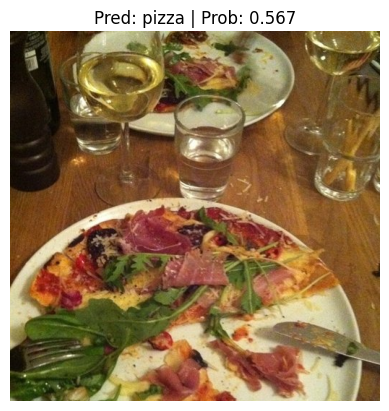

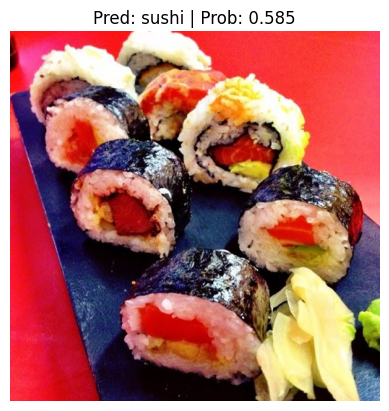

In [51]:
# Get a random list of image paths

import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                      k=num_images_to_plot)

# Make prediction on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                       image_path=image_path,
                       class_names=class_names,
                       image_size=(224, 224))

# Making predictions on a custom image.

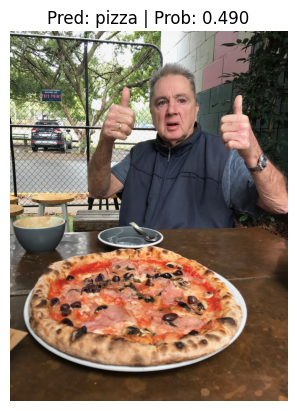

In [52]:
custom_image_path = data_path / "04-pizza-dad.jpeg"

pred_and_plot_image(
    model=model,
    image_path=custom_image_path,
    class_names=class_names
)